# Processing of Data from 2018-06-18

In [2]:
import os
import sys
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial as spa
import scipy.optimize as spo
import trackpy as tp
import pims

import support as sp

from tqdm import tqdm_notebook

from pims import pipeline
@pipeline
def as_gray(frame):
    red = frame[:, :, 0]
    green = frame[:, :, 1]
    blue = frame[:, :, 2]
    return 0.2125 * red + 0.7154 * green + 0.0721 * blue

idx = pd.IndexSlice
%matplotlib inline

## Experiment 1

In [2]:
directory = "Z:/LargeData/2018-06-18-Data/Experiment1/"
base_names = sp.get_names(directory,ext='avi')

In [3]:
name = base_names[-1]

In [4]:
trj = sp.load_dat(name)
trj.x = trj.x*0.1805 # microns per pixel
trj.y = trj.y*0.1805 # microns per pixel

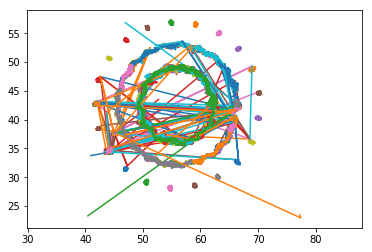

In [5]:
time = trj.index.get_level_values("time").unique().values
trj["t"] = trj.index.get_level_values("time")-time[0]
sp.draw_trj(trj)

## Experiment 2

In [4]:
directory = "Z:/LargeData/2018-06-18-Data/Experiment2/"
base_names = sp.get_names(directory,ext='avi')

In [39]:
base_names

['Z:/LargeData/2018-06-18-Data/Experiment2/Depinning_2018_06_19_10_43_37',
 'Z:/LargeData/2018-06-18-Data/Experiment2/Depinning_2018_06_19_10_44_42',
 'Z:/LargeData/2018-06-18-Data/Experiment2/Depinning_2018_06_19_10_45_47',
 'Z:/LargeData/2018-06-18-Data/Experiment2/Depinning_2018_06_19_10_46_52',
 'Z:/LargeData/2018-06-18-Data/Experiment2/Depinning_2018_06_19_10_47_57',
 'Z:/LargeData/2018-06-18-Data/Experiment2/Depinning_2018_06_19_10_49_02',
 'Z:/LargeData/2018-06-18-Data/Experiment2/Depinning_2018_06_19_10_50_07',
 'Z:/LargeData/2018-06-18-Data/Experiment2/Depinning_2018_06_19_10_51_12',
 'Z:/LargeData/2018-06-18-Data/Experiment2/Depinning_2018_06_19_10_52_17',
 'Z:/LargeData/2018-06-18-Data/Experiment2/Depinning_2018_06_19_10_53_22',
 'Z:/LargeData/2018-06-18-Data/Experiment2/Depinning_2018_06_19_10_54_27',
 'Z:/LargeData/2018-06-18-Data/Experiment2/Depinning_2018_06_19_10_55_32',
 'Z:/LargeData/2018-06-18-Data/Experiment2/Depinning_2018_06_19_10_56_37',
 'Z:/LargeData/2018-06-18

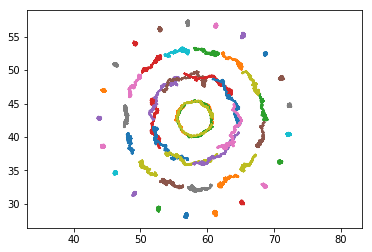

In [7]:
name = base_names[1]
trj = sp.load_dat(name)
trj.x = trj.x*0.1805 # microns per pixel
trj.y = trj.y*0.1805 # microns per pixel
time = trj.index.get_level_values("time").unique().values
trj["t"] = trj.index.get_level_values("time")-time[0]
sp.draw_trj(trj)

In [8]:
np.shape(trj.index.get_level_values("id").unique())

(49,)

In [9]:
trj.loc[np.isnan(trj.loc[sp.idx[:,:],"x"])].index.get_level_values("id").unique()

Int64Index([29], dtype='int64', name='id')

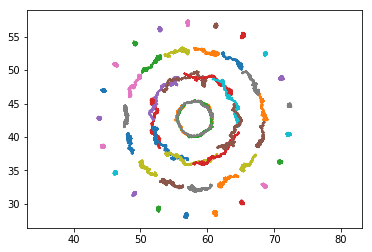

In [10]:
name = base_names[1]
trj = sp.load_dat(name)

trj = trj.drop(trj.loc[sp.idx[:,29],:].index)
np.shape(trj.index.get_level_values("id").unique())

trj.x = trj.x*0.1805 # microns per pixel
trj.y = trj.y*0.1805 # microns per pixel
time = trj.index.get_level_values("time").unique().values
trj["t"] = trj.index.get_level_values("time")-time[0]
sp.draw_trj(trj)

In [11]:
len(base_names)

600

This is a lot of experiments. I will have to hope that if the first and the last look good, all the rest also look good. 

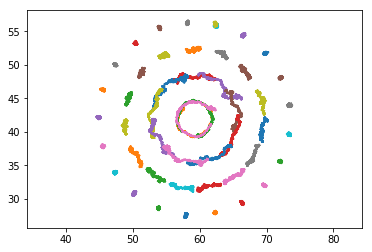

In [27]:
def load_trj(name):
    
    trj = sp.load_dat(name)

    np.shape(trj.index.get_level_values("id").unique())

    trj.x = trj.x*0.1805 # microns per pixel
    trj.y = trj.y*0.1805 # microns per pixel
    time = trj.index.get_level_values("time").unique().values
    trj["t"] = trj.index.get_level_values("time")-time[0]
    return trj

trj = load_trj(base_names[-1])
sp.draw_trj(trj)

In [28]:
trj.loc[np.isnan(trj.loc[sp.idx[:,:],"x"])].index.get_level_values("id").unique()

Int64Index([48, 29], dtype='int64', name='id')

So some experiments are not correct.

In [36]:
def incorrect_trayectory(name):
    trj = load_trj(name)
    trj = trj.drop(trj.loc[sp.idx[:,29],:].index)
    return np.any(np.isnan(trj.loc[sp.idx[:,:],"x"]))

incorrect_trayectory(base_names[0])

False

In [40]:
incorrect_files = [name for name in tqdm_notebook(base_names) if incorrect_trayectory(name)]

A Jupyter Widget

Exception in thread Thread-6:
Traceback (most recent call last):
  File "C:\ProgramFiles\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\ProgramFiles\Anaconda3\lib\site-packages\tqdm\_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "C:\ProgramFiles\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [42]:
len(incorrect_files)

388

In [44]:
with open("Z:/LargeData/2018-06-18-Data/Experiment2_Incorrect_LV_tracking.dat", 'w') as f:
    for name in incorrect_files:
        f.write(name+"\n")

## Processing of Files with correct LV tracking

Even correct files all have the 29th bogus particle. This should be removed

In [47]:
correct_files = [name for name in base_names if not (name in incorrect_files)]

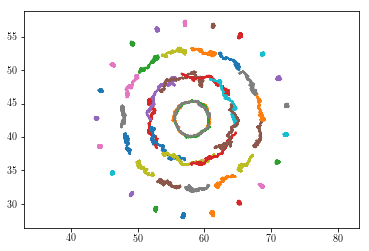

In [321]:
def load_trj(name):
    
    trj = sp.load_dat(name)

    trj = trj.drop(trj.loc[sp.idx[:,29],:].index)

    trj.x = trj.x*0.1805 # microns per pixel
    trj.y = trj.y*0.1805 # microns per pixel

    time = trj.index.get_level_values("time")
    time = pd.to_datetime(time.values+2*3600, unit="s", origin=pd.Timestamp('1904-01-01'))

    trj["time"] = time
    trj["id"] = trj.index.get_level_values("id")
    trj = trj.set_index(["time","id"])

    return trj

trj = load_trj(correct_files[1])
sp.draw_trj(trj)

In [322]:
def include_layers(trj):
    time = trj.index.get_level_values("time").unique()
    layer_indexes = sp.layers(trj.loc[sp.idx[time[round(len(time)/2)],:],:])
    
    for i,l in enumerate(layer_indexes):
        trj.loc[sp.idx[:,layer_indexes[i]],"layer"] = i
        
    return trj

trj = include_layers(trj)

In [323]:
def recenter(trj):
    center = sp.get_center(trj[trj.layer==0])
    trj.x+=-center[0]
    trj.y+=-center[1]
    return trj

trj = recenter(trj)

In [324]:
field_filename = "Z:/LargeData/2018-06-18-Data/Field-2018-06-18.log"

field= pd.read_csv(field_filename,delim_whitespace=True)
field["time"] = pd.to_datetime(field["Time(s)"]+2*3600, unit="s", origin=pd.Timestamp('1904-01-01'))
field = field.set_index("time").filter(["X_Amplitude"])
    
def field_values(trj,field):

    time = trj.index.get_level_values("time").unique()
    
    field_re = field.reindex(field.index.append(time).sort_values(),method = "pad")
    field_re = field_re[~field_re.index.duplicated(keep='first')]
    field_re = field_re.loc[trj.index.get_level_values("time")[:]].X_Amplitude
    
    trj["field"] = field_re.values
    return trj

In [332]:
name = correct_files[1]
trj = load_trj(name)
trj = include_layers(trj)
trj = recenter(trj)
trj = field_values(trj,field)

In [333]:
trj = sp.calculate_polar(trj)
trj = sp.calculate_velocities(trj)

omegas = trj.groupby(["field","layer"]).mean().filter(["omega"])
omegas["experiment"] = experiment
results.append(omegas)

In [334]:
trj.groupby('field').mean().sort_index().rel_time.diff().mean()

-0.9999999999999998

In [341]:
results = []

failed = []

for experiment,name in tqdm_notebook(enumerate(correct_files)):
    
    trj = load_trj(name)
    trj = include_layers(trj)
    trj = recenter(trj)
    trj = field_values(trj,field)

    hdf_name = os.path.join(os.path.split(name)[0],"ProcessedData",os.path.split(name)[1])+'_field_layer.hd5'

    with pd.HDFStore(hdf_name) as hdf_trj:
        hdf_trj.put('trj',trj,format='t')

    trj = sp.calculate_polar(trj)
    trj = sp.calculate_velocities(trj)

    omegas = trj.groupby(["field","layer"]).mean().filter(["omega"])
    omegas["experiment"] = experiment

    if trj.groupby('field').mean().sort_index().rel_time.diff().mean()>0:
        omegas["direction"] = "forward"
    else:
        omegas["direction"] = "backward"

    results.append(omegas)
        
results = pd.concat(results)

A Jupyter Widget

In [351]:
results.head()

omega  experiment direction
field   layer                                
0.00000 0.0   -0.001357           0   forward
        1.0    0.001240           0   forward
        2.0    0.004757           0   forward
        3.0   -0.071706           0   forward
0.04714 0.0   -0.001522           0   forward

In [352]:
results.to_csv('Z:/LargeData/2018-06-18-Data/Experiment2/ProcessedData/field_omega_correct_lv.dat',sep='\t')

### Get statistics and Plot

In [344]:
results_stat = results.groupby(["direction","field","layer"]).mean().filter(["omega"])
results_stat['error'] = results.groupby(["direction","field","layer"]).std().filter(["omega"])/\
                            np.sqrt(results.groupby(["direction","field","layer"]).count().filter(["omega"]))
results_stat.head()

omega     error
direction field    layer                    
backward  0.047140 0.0   -0.000173  0.000198
                   1.0    0.000328  0.000723
                   2.0    0.001391  0.001520
                   3.0    0.004989  0.004843
          0.066667 0.0   -0.000011  0.000214

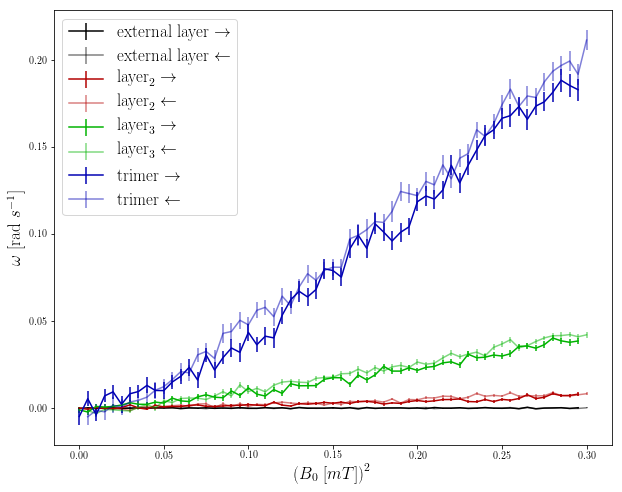

In [346]:
fig, ax = plt.subplots(1,1,figsize=[10,8])

colors = [[0,0,0],[0.7,0,0],[0,0.7,0],[0,0,0.7]]

for i in np.arange(4):

    plt.errorbar(
        (results_stat.loc[sp.idx["forward",:,i],:].index.get_level_values("field")*1.5)**2,
        -results_stat.loc[sp.idx["forward",:,i],:].omega,
        results_stat.loc[sp.idx["forward",:,i],:].error,
        color=colors[i])
    plt.errorbar(
        (results_stat.loc[sp.idx["backward",:,i],:].index.get_level_values("field")*1.5)**2,
        -results_stat.loc[sp.idx["backward",:,i],:].omega,
        results_stat.loc[sp.idx["backward",:,i],:].error,
        color=colors[i],alpha=0.5)


font_size = 17
plt.rc('text', usetex=True)
#plt.rc('font', size=font_size)
    
plt.ylabel(r"$\omega\ [\textrm{rad}\ s^{-1}]$",fontsize=font_size)
plt.xlabel(r"$\left(B_0\ [mT]\right)^2$",fontsize=font_size)

plt.legend((
    r'$\textrm{external layer} \rightarrow$',
    r'$\textrm{external layer} \leftarrow$',
    r'$\textrm{layer}_2 \rightarrow$',
    r'$\textrm{layer}_2 \leftarrow$',
    r'$\textrm{layer}_3 \rightarrow$',
    r'$\textrm{layer}_3 \leftarrow$',
    r'$\textrm{trimer} \rightarrow$',
    r'$\textrm{trimer} \leftarrow$'),fontsize=font_size)

## Processing of Files with incorrect LV tracking

In [5]:
name = incorrect_files[1]
trj = load_trj(name)

NameError: name 'incorrect_files' is not defined

In [387]:
broken_id = trj[np.isnan(trj.x)].index.get_level_values("id").unique()
trj = trj.drop(trj.loc[sp.idx[:,broken_id],:].index)

In [389]:
len(trj.index.get_level_values("id").unique())

47

In [413]:
results_inc_lv = []

lv_trj_details = []

for experiment,name in tqdm_notebook(enumerate(incorrect_files)):
    
    try:
        trj = load_trj(name)

        broken_id = trj[np.isnan(trj.x)].index.get_level_values("id").unique()
        trj = trj.drop(trj.loc[sp.idx[:,broken_id],:].index)
        no_of_particles = len(trj.index.get_level_values("id").unique())

        trj = include_layers(trj)

        lv_trj_details.append([name,no_of_particles,"OK"])

        trj = recenter(trj)
        trj = field_values(trj,field)

        hdf_name = os.path.join("C:/Users/aortiza/Desktop/","ProcessedData",os.path.split(name)[1])+'_field_layer.hd5'

        with pd.HDFStore(hdf_name) as hdf_trj:
            hdf_trj.put('trj',trj,format='t')

        trj = sp.calculate_polar(trj)
        trj = sp.calculate_velocities(trj)

        omegas = trj.groupby(["field","layer"]).mean().filter(["omega"])
        omegas["experiment"] = experiment

        if trj.groupby('field').mean().sort_index().rel_time.diff().mean()>0:
            omegas["direction"] = "forward"
        else:
            omegas["direction"] = "backward"

        results_inc_lv.append(omegas)

    except:
        
        lv_trj_details.append([name,no_of_particles,"Failed"])

        
results_inc_lv = pd.concat(results_inc_lv)

A Jupyter Widget

Exception in thread Thread-50:
Traceback (most recent call last):
  File "C:\ProgramFiles\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\ProgramFiles\Anaconda3\lib\site-packages\tqdm\_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "C:\ProgramFiles\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [415]:
results_inc_lv = pd.concat(results_inc_lv)

In [416]:
results_inc_lv.to_csv('Z:/LargeData/2018-06-18-Data/Experiment2/ProcessedData/field_omega_incorrect_lv.dat',sep='\t')

In [420]:
results_inc_lv.head()

omega  experiment direction
field   layer                                
0.00000 0.0   -0.000382           0   forward
        1.0   -0.004802           0   forward
        2.0    0.013914           0   forward
        3.0    0.083782           0   forward
0.04714 0.0    0.002589           0   forward

## Combine

In [429]:
results_cor_lv = pd.read_csv('Z:/LargeData/2018-06-18-Data/Experiment2/ProcessedData/field_omega_correct_lv.dat',
                     sep = '\t',index_col = ["field","layer"])
results_inc_lv = pd.read_csv('Z:/LargeData/2018-06-18-Data/Experiment2/ProcessedData/field_omega_incorrect_lv.dat',
                     sep = '\t',index_col = ["field","layer"])

results = pd.concat([results_cor_lv,results_inc_lv])

In [430]:
results_stat = results.groupby(["direction","field","layer"]).mean().filter(["omega"])
results_stat['error'] = results.groupby(["direction","field","layer"]).std().filter(["omega"])/\
                            np.sqrt(results.groupby(["direction","field","layer"]).count().filter(["omega"]))
results_stat.head()

omega     error
direction field    layer                    
backward  0.047140 0.0   -0.000060  0.000132
                   1.0    0.000471  0.000483
                   2.0    0.002004  0.001016
                   3.0    0.006892  0.003118
          0.066667 0.0   -0.000028  0.000145

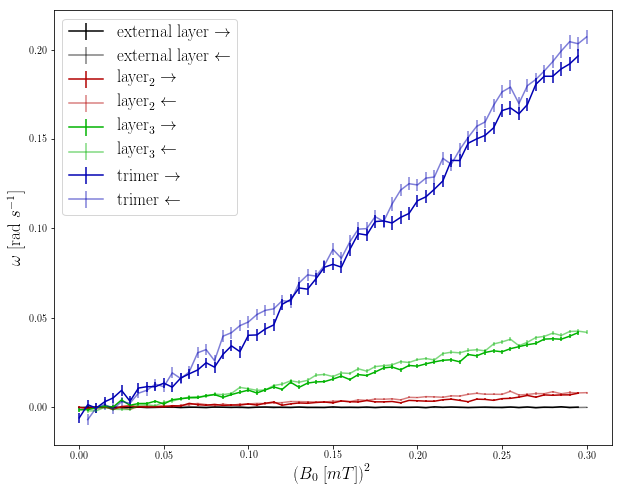

In [431]:
fig, ax = plt.subplots(1,1,figsize=[10,8])

colors = [[0,0,0],[0.7,0,0],[0,0.7,0],[0,0,0.7]]

for i in np.arange(4):

    plt.errorbar(
        (results_stat.loc[sp.idx["forward",:,i],:].index.get_level_values("field")*1.5)**2,
        -results_stat.loc[sp.idx["forward",:,i],:].omega,
        results_stat.loc[sp.idx["forward",:,i],:].error,
        color=colors[i])
    plt.errorbar(
        (results_stat.loc[sp.idx["backward",:,i],:].index.get_level_values("field")*1.5)**2,
        -results_stat.loc[sp.idx["backward",:,i],:].omega,
        results_stat.loc[sp.idx["backward",:,i],:].error,
        color=colors[i],alpha=0.5)


font_size = 17
plt.rc('text', usetex=True)
#plt.rc('font', size=font_size)
    
plt.ylabel(r"$\omega\ [\textrm{rad}\ s^{-1}]$",fontsize=font_size)
plt.xlabel(r"$\left(B_0\ [mT]\right)^2$",fontsize=font_size)

plt.legend((
    r'$\textrm{external layer} \rightarrow$',
    r'$\textrm{external layer} \leftarrow$',
    r'$\textrm{layer}_2 \rightarrow$',
    r'$\textrm{layer}_2 \leftarrow$',
    r'$\textrm{layer}_3 \rightarrow$',
    r'$\textrm{layer}_3 \leftarrow$',
    r'$\textrm{trimer} \rightarrow$',
    r'$\textrm{trimer} \leftarrow$'),fontsize=font_size)

# Repeat tracking with trackpy

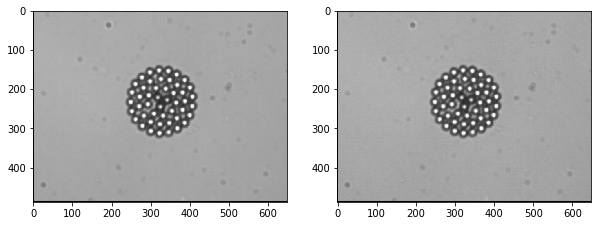

In [6]:
name = base_names[-1]
video = pims.Video(name+'.avi')
NumberOfFrames=video.get_metadata()["nframes"]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.imshow(video[0])
ax2.imshow(video[1]);

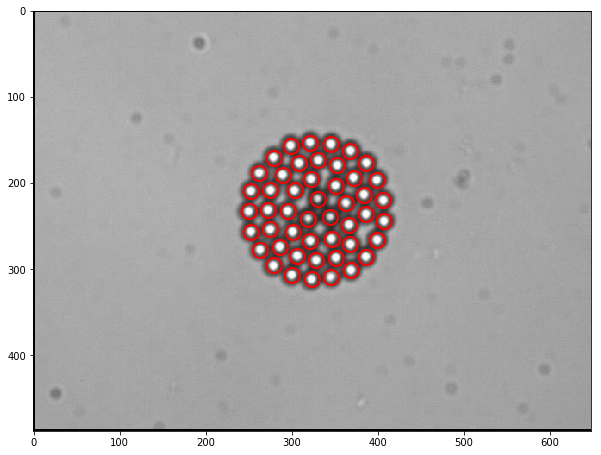

(48, 9)


In [7]:
frame = -1
f = tp.locate(as_gray(video[frame]), 19, invert=False, threshold = 7)

fig, ax = plt.subplots(1,1,figsize=(10,10))
tp.annotate(f, video[frame]);
print(np.shape(f))

In [8]:
errors = []

for name in tqdm_notebook(base_names[:]):
    try:
        video = pims.Video(name+'.avi')
        print(name)
        NumberOfFrames=video.get_metadata()["nframes"]
        f = tp.batch(as_gray(video[:]), 19, invert=False, threshold = 7, characterize = False, engine='numba')
        trj = tp.link(f, 10)
        new_name = os.path.join(os.path.split(name)[0],"ProcessedData",os.path.split(name)[1])+'_trackpy.dat'
        trj.filter(["particle","frame","x","y"]).to_csv(name+'_trackpy.dat',sep="\t")
    except Exception as e:
        number = [i for i,n in enumerate(base_names) if name==n][0]
        errors.append([number,name,e])

Frame 3600: 48 trajectories present.



# Relink with memory. 

In [3]:
directory = "C:/Users/aortiza/Desktop/Experiment2/"
base_names = sp.get_names(directory,ext='.dat')

base_names = [
    names[:names.find('trackpy')-1] for names in base_names if (names.find('trackpy')>0) & (names.find('ProcessedData')<0)]

In [4]:
for name in base_names:
    trj = pd.read_csv(name+"_trackpy.dat",sep="\t")
    find = trj.filter(["frame","x","y"])
    trj = tp.link(find, 10, memory = 5)

    trj = trj.set_index(["frame","particle"]).filter(["x","y"])
    trj_len = trj.groupby("particle").count()
    trj = trj.loc[idx[:,trj_len[trj_len["x"]>1000].index],:]
    
    new_name = os.path.join(os.path.split(name)[0],"ProcessedData",os.path.split(name)[1])+'_trackpy_mem.dat'
    trj.to_csv(new_name,sep="\t")

Frame 3600: 48 trajectories present.


# Process trayectory to include real time, and field. 

In [13]:
directory = "C:/Users/aortiza/Desktop/Experiment2/ProcessedData/"
base_names = sp.get_names(directory,ext='.dat')

In [14]:
def new_name(name):
    return os.path.join(os.path.split(name)[0],"ProcessedData",os.path.split(name)[1])+'_trackpy_mem.dat'

def from_frame_to_real_time(trj,name):
    """ Asigns labview timestamp to the frames of trj"""
    trj_real_time = pd.read_csv(name+'.dat',sep="\t",header=None)
    time = pd.to_datetime(trj_real_time[0].values+2*3600, unit="s", origin=pd.Timestamp('1904-01-01'))

    trj["time"] = time[trj.index.get_level_values("frame")]
    trj["id"] = trj.index.get_level_values("particle")
    trj = trj.set_index(["time","id"])
    return trj

def from_px_to_um(trj,px_size):
    trj.x = trj.x*px_size # microns per pixel
    trj.y = trj.y*px_size # microns per pixel
    return trj

def add_layers(trj):
    time = trj.index.get_level_values("time").unique()
    layer_indexes = sp.layers(trj.loc[sp.idx[time[round(len(time)/2)],:],:])
    
    for i,l in enumerate(layer_indexes):
        trj.loc[sp.idx[:,layer_indexes[i]],"layer"] = i
        
    return trj

def recenter(trj):
    center = sp.get_center(trj[trj.layer==0])
    trj.x+=-center[0]
    trj.y+=-center[1]
    return trj

field_filename = "Z:/LargeData/2018-06-18-Data/Field-2018-06-18.log"

field= pd.read_csv(field_filename,delim_whitespace=True)
field["time"] = pd.to_datetime(field["Time(s)"]+2*3600, unit="s", origin=pd.Timestamp('1904-01-01'))
field = field.set_index("time").filter(["X_Amplitude"])
    
def field_values(trj,field):

    time = trj.index.get_level_values("time").unique()
    
    field_re = field.reindex(field.index.append(time).sort_values(),method = "pad")
    field_re = field_re[~field_re.index.duplicated(keep='first')]
    field_re = field_re.loc[trj.index.get_level_values("time")[:]].X_Amplitude
    
    trj["field"] = field_re.values
    return trj

In [15]:
errors = []

for experiment,name in tqdm_notebook(enumerate(base_names[:])):
    try:
        trj = pd.read_csv(name+'.dat',sep="\t",index_col=["frame","particle"])
        trj = from_frame_to_real_time(trj,name.replace("_trackpy_mem","").replace("ProcessedData/",""))
        trj = from_px_to_um(trj,0.1805)
        trj = add_layers(trj)
        trj = recenter(trj)
        trj = field_values(trj,field)

        hdf_name = name.replace("_trackpy_mem","")+'_field_layer.hd5'

        with pd.HDFStore(hdf_name) as hdf_trj:
            hdf_trj.put('trj',trj,format='t')
            
            trj = sp.calculate_polar(trj)
            trj = sp.calculate_velocities(trj)

            omegas = trj.groupby(["field","layer"]).mean().filter(["omega"])
            omegas["experiment"] = experiment

            if trj.groupby('field').mean().sort_index().rel_time.diff().mean()>0:
                omegas["direction"] = "forward"
            else:
                omegas["direction"] = "backward"

            hdf_trj.put("omegas",omegas,format='t')
            
    except Exception as e:
        number = [i for i,n in enumerate(base_names) if name==n][0]
        errors.append([number,name,e])
        print([number, name, e])

A Jupyter Widget

[163, 'C:/Users/aortiza/Desktop/Experiment2/ProcessedData/Depinning_2018_06_19_13_40_12_trackpy_mem', QhullError('QH6214 qhull input error: not enough points(1) to construct initial simplex (need 4)\n\nWhile executing:  | qhull d Qc Qbb Q12 Qz Qt\nOptions selected for Qhull 2015.2.r 2016/01/18:\n  run-id 166313530  delaunay  Qcoplanar-keep  Qbbound-last  Q12-no-wide-dup\n  Qz-infinity-point  Qtriangulate  _pre-merge  _zero-centrum  Qinterior-keep\n',)]
[225, 'C:/Users/aortiza/Desktop/Experiment2/ProcessedData/Depinning_2018_06_19_14_47_22_trackpy_mem', QhullError('QH6214 qhull input error: not enough points(1) to construct initial simplex (need 4)\n\nWhile executing:  | qhull d Qc Qbb Q12 Qz Qt\nOptions selected for Qhull 2015.2.r 2016/01/18:\n  run-id 167523634  delaunay  Qcoplanar-keep  Qbbound-last  Q12-no-wide-dup\n  Qz-infinity-point  Qtriangulate  _pre-merge  _zero-centrum  Qinterior-keep\n',)]
[457, 'C:/Users/aortiza/Desktop/Experiment2/ProcessedData/Depinning_2018_06_19_18_58_4

In [16]:
directory = "C:/Users/aortiza/Desktop/Experiment2/ProcessedData/"
base_names = sp.get_names(directory,ext='.hd5')

In [17]:
def load_omegas(name):
    with pd.HDFStore(name+'.hd5') as hdf_trj:
        return hdf_trj.select('omegas')
results = pd.concat([load_omegas(name) for name in tqdm_notebook(base_names)])

A Jupyter Widget

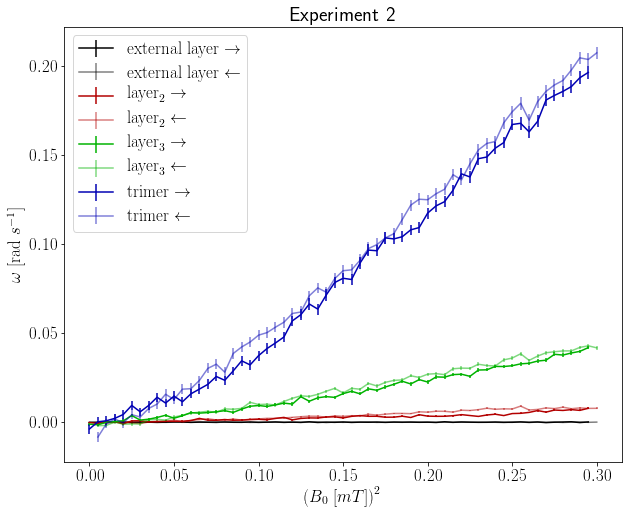

In [18]:
results_stat = results.groupby(["direction","field","layer"]).mean().filter(["omega"])
results_stat['error'] = results.groupby(["direction","field","layer"]).std().filter(["omega"])/\
                            np.sqrt(results.groupby(["direction","field","layer"]).count().filter(["omega"]))
results_stat.head()

fig, ax = plt.subplots(1,1,figsize=[10,8])

colors = [[0,0,0],[0.7,0,0],[0,0.7,0],[0,0,0.7]]

for i in np.arange(4):

    plt.errorbar(
        (results_stat.loc[sp.idx["forward",:,i],:].index.get_level_values("field")*1.5)**2,
        -results_stat.loc[sp.idx["forward",:,i],:].omega,
        results_stat.loc[sp.idx["forward",:,i],:].error,
        color=colors[i])
    plt.errorbar(
        (results_stat.loc[sp.idx["backward",:,i],:].index.get_level_values("field")*1.5)**2,
        -results_stat.loc[sp.idx["backward",:,i],:].omega,
        results_stat.loc[sp.idx["backward",:,i],:].error,
        color=colors[i],alpha=0.5)


font_size = 17
plt.rc('text', usetex=True)
plt.rc('font', size=font_size)

plt.title(r"Experiment 2")
plt.ylabel(r"$\omega\ [\textrm{rad}\ s^{-1}]$",fontsize=font_size)
plt.xlabel(r"$\left(B_0\ [mT]\right)^2$",fontsize=font_size)

plt.legend((
    r'$\textrm{external layer} \rightarrow$',
    r'$\textrm{external layer} \leftarrow$',
    r'$\textrm{layer}_2 \rightarrow$',
    r'$\textrm{layer}_2 \leftarrow$',
    r'$\textrm{layer}_3 \rightarrow$',
    r'$\textrm{layer}_3 \leftarrow$',
    r'$\textrm{trimer} \rightarrow$',
    r'$\textrm{trimer} \leftarrow$'),fontsize=font_size)